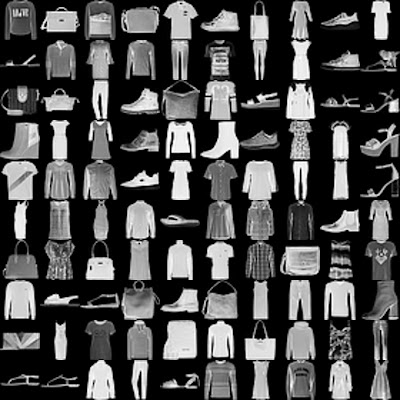

In [1]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml

In [2]:
mnist_fashion = fetch_openml('Fashion-MNIST')

C:\Users\MuhammadWasim\anaconda3\envs\deep\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist_fashion.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist_fashion.data.shape

(70000, 784)

In [5]:
28*28

784

In [6]:
print(mnist_fashion.DESCR)

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Description  
0  T-shirt/top  
1  Trouser  
2  Pullover  
3  Dress  
4  

In [7]:
from matplotlib import pyplot as plt

In [8]:
mnist_fashion.target.values[0]

'9'

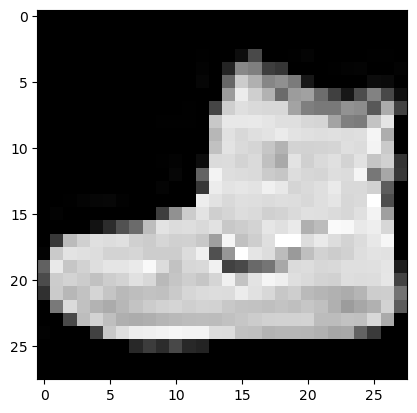

In [9]:
plt.imshow(mnist_fashion.data.values[0].reshape(28,28), cmap='gray')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class mf_dataset(Dataset):
    
    def __init__(self):
        self.X = torch.tensor(mnist_fashion.data.values, dtype=torch.float32, device=device)
        self.y = torch.tensor(mnist_fashion.target.astype(np.float32), dtype=torch.float32, device=device)
        self.sampels = self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.sampels

In [20]:
from torch.utils.data import random_split

In [21]:
dataset = mf_dataset()

train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [22]:
len(train_dataset), len(test_dataset)

(56000, 14000)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        output = torch.relu(self.fc1(x))
        output = torch.relu(self.fc2(output))
        output = self.fc3(output)
        
        return output

In [26]:
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
epochs = 15
train_acc = []
test_acc = []

In [32]:
for epoch in range(epochs):
    model.train()
    
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)   # [0.3, 0.5, 0.2]
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    train_loss /= len(train_loader)
    train_accuracy = 100.0 * train_correct / train_total
    train_acc.append(train_accuracy)
    
    # Testing
    model.eval()
    test_predictions = []
    test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            test_predictions.extend(predicted.tolist())
            test_labels.extend(labels.tolist())
            
    test_accuracy = 100.0 * accuracy_score(test_labels, test_predictions)
    test_acc.append(test_accuracy)
    
    print(f"Epoch [{epoch + 1}/{epochs} - Train acc: {train_accuracy:.2f} - Test Acc: {test_accuracy:.2f}")

Epoch [1/15 - Train acc: 79.75 - Test Acc: 82.93
Epoch [2/15 - Train acc: 83.87 - Test Acc: 83.82
Epoch [3/15 - Train acc: 85.32 - Test Acc: 85.35
Epoch [4/15 - Train acc: 85.99 - Test Acc: 85.26
Epoch [5/15 - Train acc: 86.53 - Test Acc: 85.15
Epoch [6/15 - Train acc: 86.77 - Test Acc: 84.94
Epoch [7/15 - Train acc: 87.16 - Test Acc: 85.62
Epoch [8/15 - Train acc: 87.42 - Test Acc: 85.16
Epoch [9/15 - Train acc: 87.81 - Test Acc: 86.20
Epoch [10/15 - Train acc: 87.82 - Test Acc: 86.05
Epoch [11/15 - Train acc: 88.01 - Test Acc: 83.76
Epoch [12/15 - Train acc: 88.09 - Test Acc: 85.45
Epoch [13/15 - Train acc: 88.07 - Test Acc: 87.29
Epoch [14/15 - Train acc: 88.38 - Test Acc: 85.03
Epoch [15/15 - Train acc: 88.63 - Test Acc: 86.99


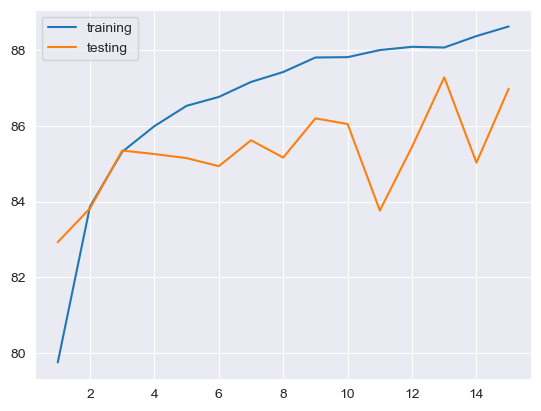

In [36]:
import seaborn as sns
sns.set_style('darkgrid')

sns.lineplot(x=range(1,16), y=train_acc, label='training')
sns.lineplot(x=range(1,16), y=test_acc, label='testing')

plt.legend()
plt.show()